# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Для исследования предоставлены пробы нефти в трех регионах: в каждом 10000 месторождений, где измерили качество нефти и объем ее запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль. Проанализировать возможную прибыль и риски нужно, используя технику *Bootstrap*.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков.
- Строят модель и оценивают объем запасов.
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
- Прибыль равна суммарной прибыли отобранных месторождений.

**<u>Описание данных</u>**

Данные геологоразведки трех регионов находятся в файлах:

- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`


 - `id` — уникальный идентификатор скважины
 - `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
 - `product` — объем запасов в скважине (тыс. баррелей)


**<u>Условия задачи</u>**


- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют `500 точек`, из которых с помощью машинного обучения выбирают `200 лучших` для разработки.
- Бюджет на разработку скважин в регионе — `10 млрд рублей`.
- При нынешних ценах один баррель сырья приносит `450 рублей` дохода. Доход с каждой единицы продукта составляет `450 тыс. рублей`, поскольку объем указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше `2.5%`. Среди них выбирают регион с наибольшей средней прибылью.

**<u>План работы</u>**

**1.** Загрузка и подготовка данных с поясненем порядка действий.


**2.** Обучение и проверка модели для каждого региона:
* Разбивка данных на обучающую и валидационную выборки в соотношении `75:25`.
* Обучение модели и предсказание на валидационной выборке.
* Сохранение предсказаний и правильных ответов на валидационной выборке.
* Вывод на экран среднего запаса предсказанного сырья и *RMSE* модели.
* Анализ результатов.
 
 
**3.** Подготовка к расчету прибыли:
* Сохранение всех ключевых значений для расчетов в отдельных переменных.
* Расчет достаточного объема сырья для безубыточной разработки новой скважины. Сравнение полученного объема сырья со средним запасом в каждом регионе. 
* Выводы по этапу подготовки расчёета прибыли.
 
 
**4.** Создание функции для расчета прибыли по выбранным скважинам и предсказаниям модели:
* Выбрать скважины с максимальными значениями предсказаний. 
* Суммировние целевого значения объема сырья, соответствующего этим предсказаниям.
* Расчет прибыли для полученного объема сырья.
 
 
**5.** Расчет рисков и прибыли для каждого региона:
* Применение техники *Bootstrap* с `1000` выборок, чтобы найти распределение прибыли.
* Определение средней прибыль, `95%`-й доверительного интервала и риска убытков. Убыток — это отрицательная прибыль.
* Выводы: выбор региона для разработки скважин и обоснование выбора.

## Загрузка и подготовка данных

In [1]:
!pip install phik -q

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from numpy.random import RandomState

pd.set_option('display.max_columns', None)

%matplotlib inline

RANDOM_STATE = 42

In [3]:
# сохраним датафреймы в переменные
# поскольку далее мы будем оперировать понятиями "первый регион", "второй регион", "третий регион", назовем их соответственно
region_1 = pd.read_csv('datasets/geo_data_0.csv')
region_2 = pd.read_csv('datasets/geo_data_1.csv')
region_3 = pd.read_csv('datasets/geo_data_2.csv')

In [4]:
# просмотрим первые строки первого датафрейма
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
# просмотрим общую информацию о датафрейме
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
# просмотрим первые строки второго датафрейма
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
# просмотрим общую информацию о датафрейме
region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# просмотрим первые строки третьего датафрейма
region_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
# просмотрим общую информацию о датафрейме
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все три датафрейма имеют одинаковую размерность: `100000` строк и `5` столбцов. Данные представлены вещественными и строковыми значениями. Пропусков нет.

**Вывод:**

* Типы данных соответствуют описанию.
* Названия колонок соответствуют общепринятым стандартам.
* В данных нет пропусков.    

----------

Выполним подготовку данных для дальнейшей работы. 

Признак `id` не является информативным для обучения модели, поэтому удалим соответствующий столбец из всех датафреймов.

In [10]:
region_1 = region_1.drop('id', axis=1)
region_2 = region_2.drop('id', axis=1)
region_3 = region_3.drop('id', axis=1)

Проверим, выполнилось ли удаление.

In [11]:
print('Размерность датафрейма region_1 после удаления столбца id:', region_1.shape)
print('Размерность датафрейма region_2 после удаления столбца id:', region_2.shape)
print('Размерность датафрейма region_3 после удаления столбца id:', region_3.shape)

Размерность датафрейма region_1 после удаления столбца id: (100000, 4)
Размерность датафрейма region_2 после удаления столбца id: (100000, 4)
Размерность датафрейма region_3 после удаления столбца id: (100000, 4)


Итак, мы видим, что осталось 4 столбца. Удаление выполнено успешно.

Теперь проверим наличие **явных дубликатов** в данных.

In [12]:
print('Количество явных дубликатов в датафрейме первого региона:', region_1.duplicated().sum())
print('Количество явных дубликатов в датафрейме второго региона:', region_2.duplicated().sum())
print('Количество явных дубликатов в датафрейме третьего региона:', region_3.duplicated().sum())

Количество явных дубликатов в датафрейме первого региона: 0
Количество явных дубликатов в датафрейме второго региона: 0
Количество явных дубликатов в датафрейме третьего региона: 0


**Неявные дубликаты** в данном случае искать нецелесообразно, поскольку показатели разных скважин могут быть одинаковыми.

---------

Посмотрим распределение вещественных значений во всех датафреймах. Для начала изучим статистику по каждому датафрейму.

In [13]:
region_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [14]:
region_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [15]:
region_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Теперь построим графики, чтобы наглядно оценить распределение признаков. Напишем функции для построения гистограмм и ящиков с усами.

In [16]:
# функция для построения гистограмм
def create_histograms(df, df_name):
    position = 0

    plt.figure(figsize=[15, 20])
    plt.subplots_adjust(top=0.95, wspace=0.2, hspace=0.5)
    plt.suptitle('Гистограммы для вещественных значений', fontsize=15)

    for column_name in df.columns:
        position += 1
        plt.subplot(3, 4, position)
        sns.set_style('whitegrid')

        plt.title(f'Гистограмма для {column_name.upper()} региона {df_name[-1]}', fontsize=10)
        sns.histplot(data=df[column_name], kde=False)
        plt.ylabel('Количество')

    plt.show();    
    

# функция для построения ящиков с усами
def create_boxplots(df, df_name):
    position = 0

    plt.figure(figsize=[15, 20])
    plt.subplots_adjust(top=0.95, wspace=0.2, hspace=0.5)
    plt.suptitle('Ящики с усами для вещественных значений', fontsize=15)

    for column_name in df.columns:
        position += 1
        plt.subplot(3, 4, position)
        sns.set_style('whitegrid')

        plt.title(f'Ящик с усами для {column_name.upper()} региона {df_name[-1]}', fontsize=10)
        sns.set_style('whitegrid')

        sns.boxplot(data=df[column_name], orient='h')

        plt.axvline(np.mean(df[column_name]),
                    color='r',
                    linestyle='-',
                    label='Среднее')

        plt.legend(title=f'Среднее: {np.mean(df[column_name]):.2f}. Медиана: {np.median(df[column_name]):.2f}', 
                   loc='center', 
                   edgecolor='r',
                   facecolor='lightblue',
                   bbox_to_anchor=(0.5, -0.15))

    plt.show();

Построим **графики для первого региона**.

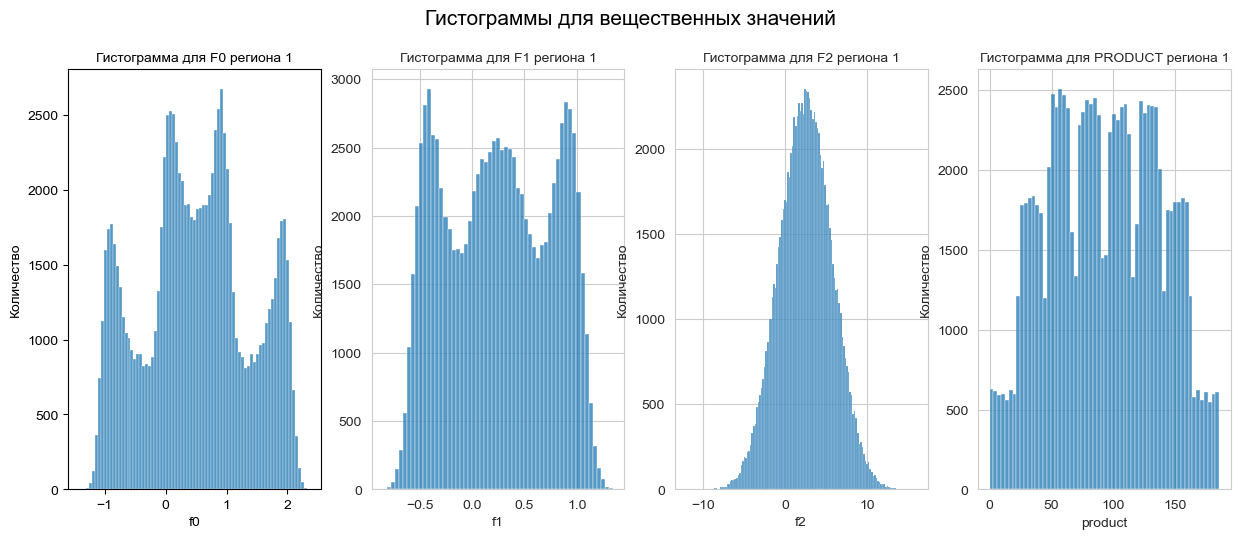

In [17]:
create_histograms(region_1, 'region_1')

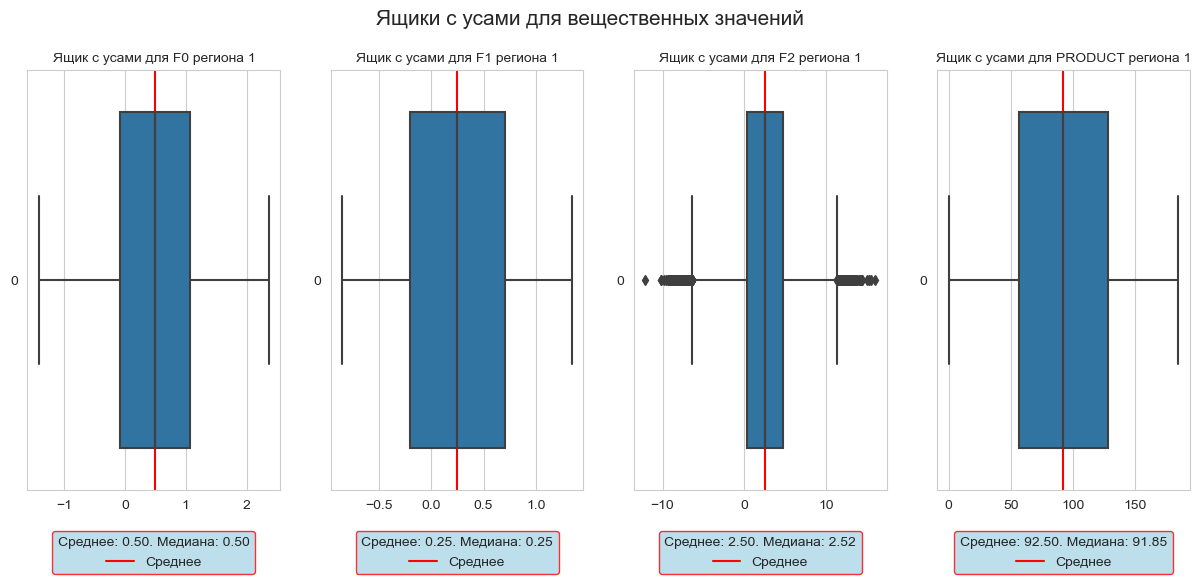

In [18]:
create_boxplots(region_1, 'region_1')

Как можно видеть, признак `f2` первого региона имеет нормальное распределение, есть выбросы, их удалять не будем, поскольку доподлинно неизвестно, что означают эти признаки, вероятно, это реальные замеры. Остальные признаки не имеют выбросов.

Средний запас сырья в скважинах первого региона: `92.5` тыс. баррелей.

Построим **графики для второго региона**.

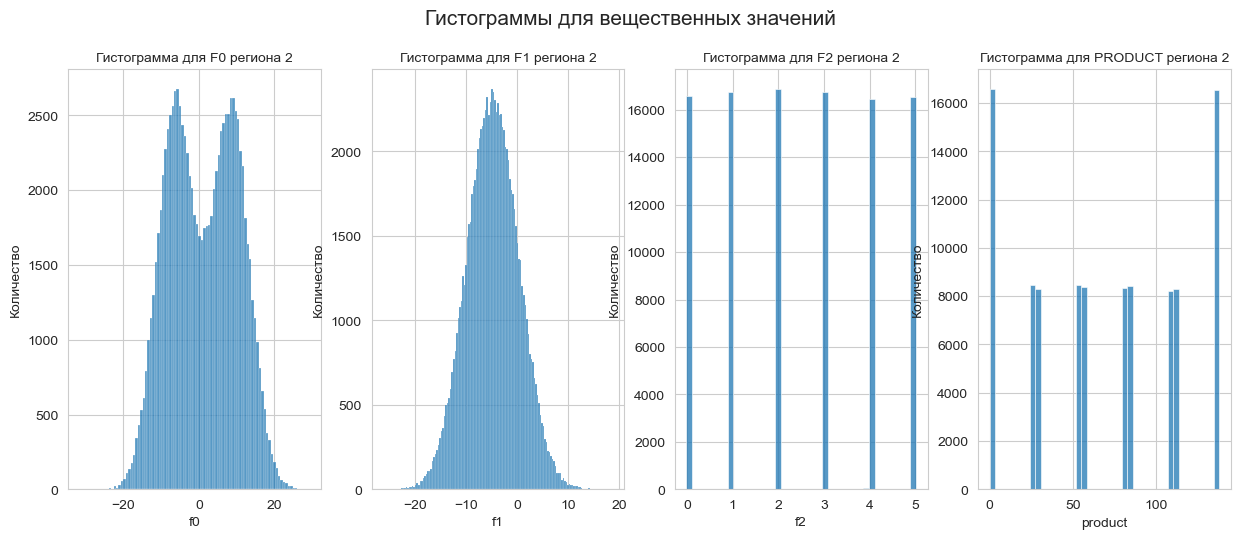

In [19]:
create_histograms(region_2, 'region_2')

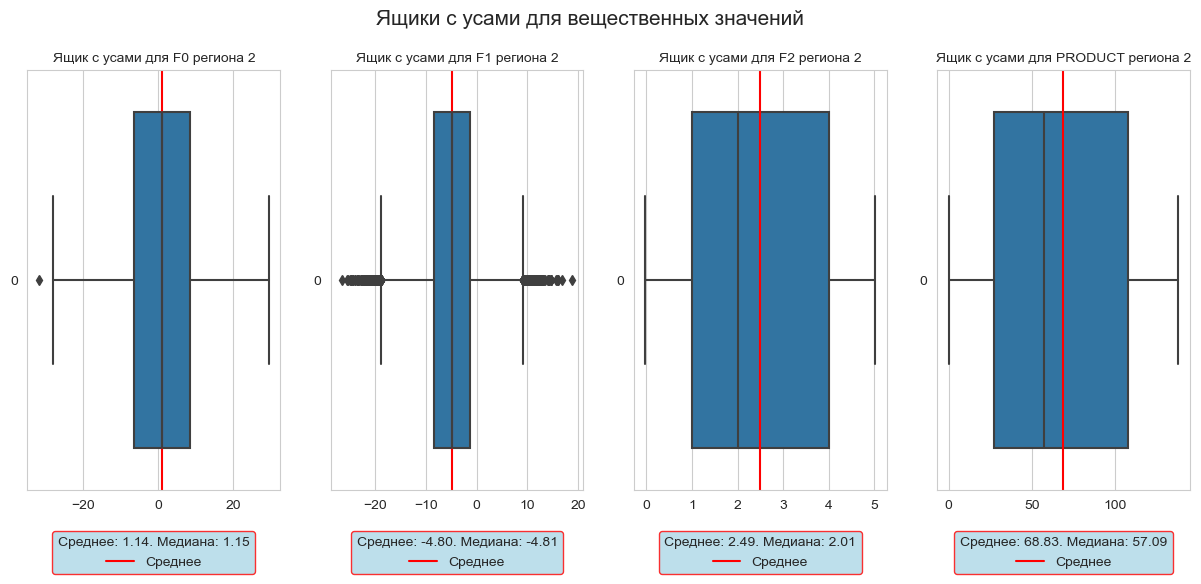

In [20]:
create_boxplots(region_2, 'region_2')

Из полученных графиков видно, что нормальное распределение имеет признак `f1` второго региона, также имеются выбросы, которые мы не будем удалять по причинам, обозначенным мною выше для первого региона.

Средний запас сырья в скважинах первого региона: `68.83` тыс. баррелей.

Построим **графики для третьего региона**.

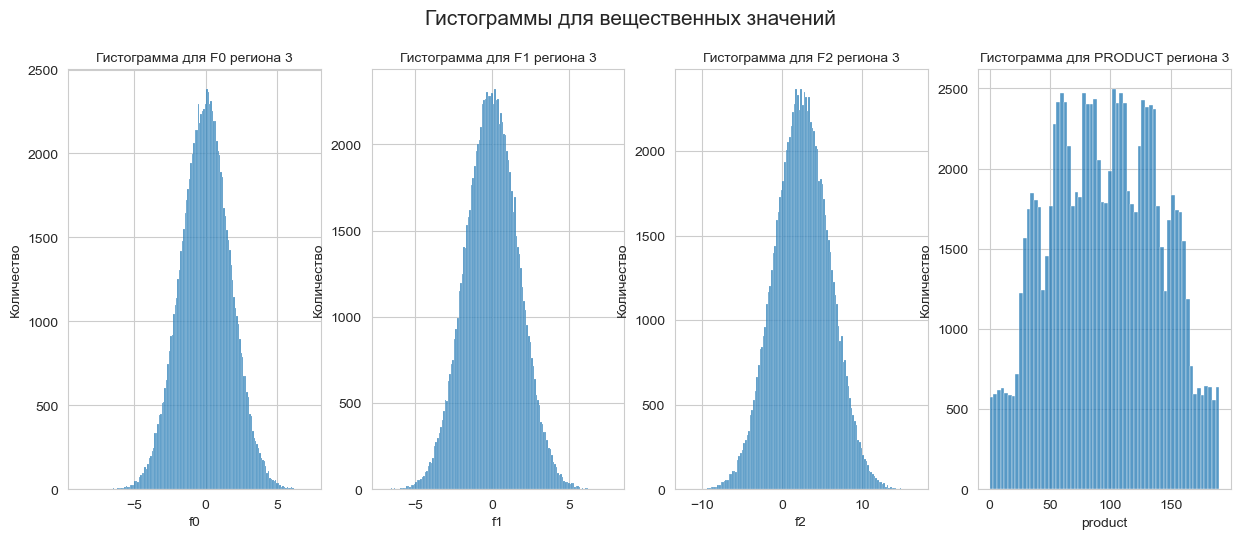

In [21]:
create_histograms(region_3, 'region_3')

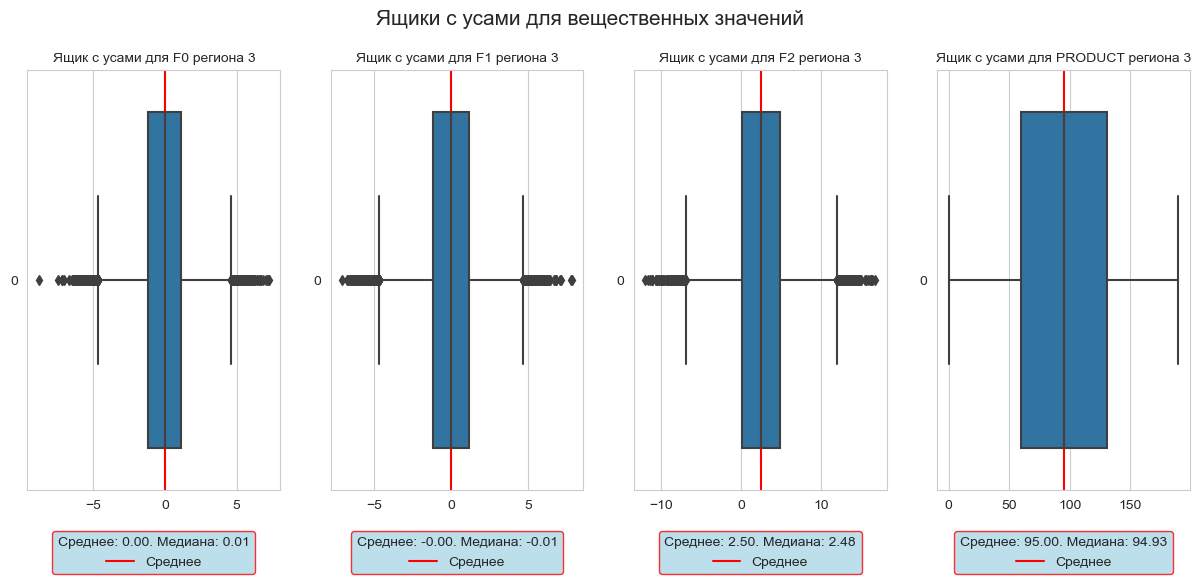

In [22]:
create_boxplots(region_3, 'region_3')

На полученных графиках видно нормальное распределение признаков `f0`, `f1`, `f2` третьего региона, также все три признака имеют выбросы. Удалять выбросы не будем по тем же причинам, что и для первых двух регионов.

Средний запас сырья в скважинах первого региона: `95` тыс. баррелей.

----------

Тепепь стоит посмотреть **корреляцию признаков** в представленных датафреймах. Построим матрицу *Phik*, которая широко используется для анализа корреляции между переменными в наборах данных.

In [23]:
# функция построения матрицы корреляции
def plot_correlation_heatmaps(dataframes):
    # определим столбцы, которые имеют интервальные значения
    interval_cols = ['f0', 'f1', 'f2', 'product']
    for region, df in dataframes.items():
       # расчет коэффициентов корреляции Phik
        correlation_matrix = phik.phik_matrix(df, interval_cols=interval_cols)
        
        # построение графика корреляции
        plt.figure(figsize=(10, 5))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
        
        plt.title(f"Матрица корреляции (Phik) - {region}")
        plt.show();

In [24]:
dataframes = {'Регион 1': region_1, 'Регион 2': region_2, 'Регион 3': region_3}

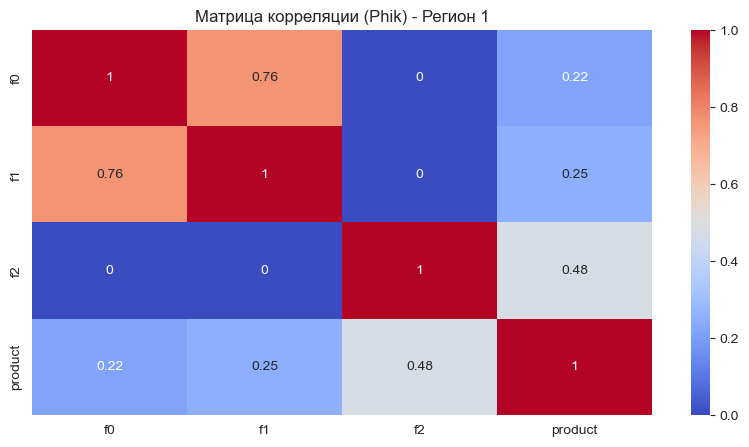

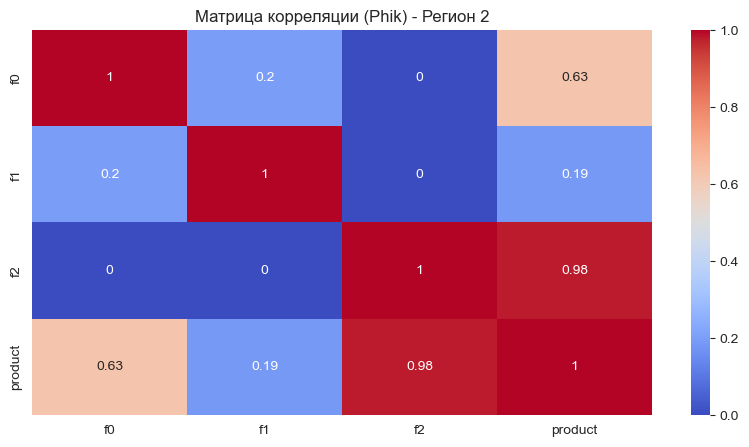

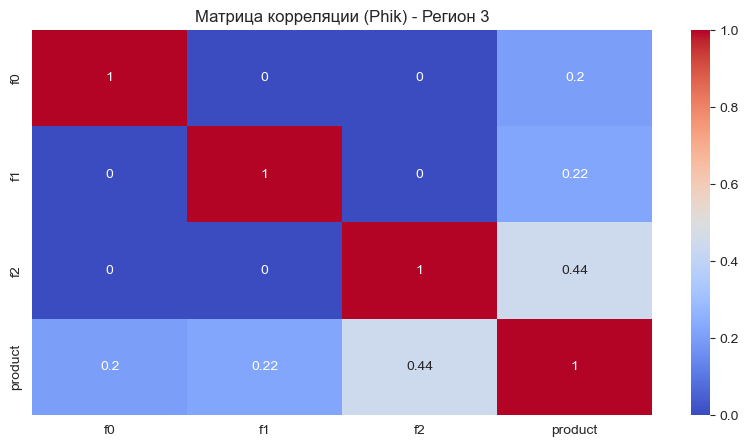

In [25]:
plot_correlation_heatmaps(dataframes)

**Выводы по матрице кореляции:**

<u>Первый регион</u>: видим высокую корреляцию (`0.76`) между признаками `f0` и `f1`, умеренную корреляцию (`0.48`) между признаком `f2` и целевой переменной `product`, остальные признаки либо коррелируют между собой слабо, либо вообще не коррелируют.

<u>Второй регион</u>: видим весьма высокую корреляцию (`0.98`) между признаком `f2` и целевой переменной `product`, заметную корреляцию (`0.63`) между признаком `f0` и целевой переменной `product`, остальные признаки либо коррелируют между собой слабо, либо вообще не коррелируют. Сильная корреляция в этом регионе возникает в связи с небольшим количеством уникальных значений целевого признака.

<u>Третий регион</u>: видим умеренную корреляцию (`0.44`) между признаком `f2` и целевой переменной `product`, остальные признаки либо коррелируют между собой слабо, либо вообще не коррелируют.

<u>**Выводы по загрузке и подготовке данных**:</u>
    
Типы данных во всех датафреймах соответствуют описанию, названия колонок соответствуют общепринятым стандартам, в данных нет пропусков.

Признак `id` не является информативным для обучения модели, поэтому был удален из всех датафреймов.

При построении графиков были обнаружены выбросы в некоторых признаках, удалять их не стали, поскольку мы не знаем, что именно представляют собой эти данные, поэтому есть вероятность, что показатели достоверны и имеют место быть.

Средний запас сырья в скважине в регионах:

* первый регион: `92.5` тыс. баррелей,
* второй регион: `68.83` тыс. баррелей,
* третий регион: `95` тыс. баррелей.

При изучении корреляции признаков выявлена весьма высокая положительная корреляция между признаком `f2` и целевым признаком `product`. Остальные признаки во всех датафреймах имеют разную степень корреляции, сключая слабую или вообще ее отсутствие.

## Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25. Для этого напишем функцию.

In [26]:
# функция для разбивки данных
def split_data(df, target_column):
    features = df.drop(columns=target_column, axis=1)
    target = df[target_column]
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    return features_train, features_valid, target_train, target_valid

Выполним разбиение.

In [27]:
features_train_r1, target_train_r1, features_valid_r1, target_valid_r1 = split_data(region_1, 'product')
features_train_r2, target_train_r2, features_valid_r2, target_valid_r2 = split_data(region_2, 'product')
features_train_r3, target_train_r3, features_valid_r3, target_valid_r3 = split_data(region_3, 'product')

Напишем функцию обучения модели линейной регрессии (`LinearRegression()`) для получения предсказанных значений объема запасов в скважинах, среднего запаса предсказанного сырья и *RMSE* модели.

In [28]:
def lr_model(X_train, y_train, X_valid, y_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    mean = predictions.mean()
    mse = mean_squared_error(y_valid, predictions)
    rmse = np.sqrt(mse) 
    return predictions, mean, rmse

Вызовем функцию, чтобы получить нужные данные.

In [29]:
predictions_r1, mean_r1, rmse_r1 = lr_model(features_train_r1, features_valid_r1, target_train_r1, target_valid_r1)
predictions_r2, mean_r2, rmse_r2 = lr_model(features_train_r2, features_valid_r2, target_train_r2, target_valid_r2)
predictions_r3, mean_r3, rmse_r3 = lr_model(features_train_r3, features_valid_r3, target_train_r3, target_valid_r3)

Создадим датафрейм для предсказаний запасов сырья.

In [30]:
predictions = {
    'pred_product_r1': predictions_r1,
    'pred_product_r2': predictions_r2,
    'pred_product_r3': predictions_r3
}

df_predictions = pd.DataFrame(predictions)
df_predictions.sample(5)

,pred_product_r1,pred_product_r2,pred_product_r3
20604,109.260761,83.469617,85.713803
10531,72.275993,57.017846,89.561822
23524,99.188086,135.660915,121.936174
13300,64.192032,110.743512,69.806416
16465,78.598974,57.561227,99.354197


Теперь создадим датафрейм со средними значениями запасов сырья и метрикой *RMSE* модели для каждого региона.

In [31]:
regions = [
    {'Регион': 1, 'Средний запас': mean_r1, 'RMSE': rmse_r1},
    {'Регион': 2, 'Средний запас': mean_r2, 'RMSE': rmse_r2},
    {'Регион': 3, 'Средний запас': mean_r3, 'RMSE': rmse_r3}
]

results_df = pd.DataFrame(regions)
results_df

,Регион,Средний запас,RMSE
0,1,92.398800,37.756600
1,2,68.712878,0.890280
2,3,94.771024,40.145872


<u>**Выводы**:</u>

Итак, самый высокий показатель **среднего запаса сырья** получен для третьего региона — `94.77` тыс. баррелей, при этом метрика *RMSE* (корень из среднеквадратической ошибки; чем меньше, тем лучше) имеет самое высокое значение среди всех полученных результатов - `40.15`. Наименьшее значение *RMSE* получено приработе с датафреймом второго региона - `0.89`, при этом **средний запас предсказанного сырья** самый низкий — `68.71` тыс. баррелей.

Самое лучшее качество модель показала при работе со вторым регионом, а невысокий средний запас сырья по сравнению с другими двумя регионами обусловлен тем, что большое количество скважин изначально имеют низкий запас сырья.

## Подготовка к расчету прибыли

Сохраним все ключевые значения для расчетов в отдельных переменных.

In [32]:
NUMBER_OF_POINTS = 500
NUMBER_OF_BEST_POINTS = 200
BUDGET = 10000000000
INCOME_PER_UNIT = 450000
LOSS_TRESHOLD = 2.5

R_STATE = np.random.RandomState(12345)

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины.

In [33]:
sufficient_volume = BUDGET/(INCOME_PER_UNIT * NUMBER_OF_BEST_POINTS)

In [34]:
print(f'\nДостаточный объем сырья для безубыточной разработки новой скважины: {sufficient_volume:.2f}')


Достаточный объем сырья для безубыточной разработки новой скважины: 111.11


Итак, мы получили достаточный объем сырья для безубыточной разработки — `111.11` тыс. баррелей. Если сравнить это значение со средним запасом в каждом регионе (первый регион — `92.4`, второй регион — `68.7`, третий регион — `94.8`), то увидим, что во всех регионах запас сырья ниже.

<u>**Вывод**:</u>

Третий регион имеет самый высокий средний показатель запасов сырья по сравнению с другими регионами и это значение наиболее близко к вычисленому выше достаточному объему сырья для безубыточной разработки.    

## Создание функции для расчета прибыли

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели:
* выберем скважины с максимальными значениями предсказаний,
* суммируем целевое значение объема сырья, соответствующее этим предсказаниям,
* рассчитаем прибыль для полученного объема сырья.

In [35]:
# подготовим данные
target_valid_r1 = target_valid_r1.reset_index(drop=True)
target_valid_r2 = target_valid_r2.reset_index(drop=True)
target_valid_r3 = target_valid_r3.reset_index(drop=True)
predictions_r1 = pd.Series(predictions_r1)
predictions_r2 = pd.Series(predictions_r2)
predictions_r3 = pd.Series(predictions_r3)

In [36]:
# функция для расчета прибыли
def income_calculate(predictions, target):
    max_value_of_predicitions_sorted = pd.Series(predictions).sort_values(ascending=False)[:NUMBER_OF_BEST_POINTS]
    product = target.reset_index(drop=True)[max_value_of_predicitions_sorted.index].sum()
    profit = product * INCOME_PER_UNIT
    return (profit - BUDGET)

Итак, можно посчитать прибыль.

In [37]:
estimated_income_r1 = income_calculate(predictions_r1, target_valid_r1)
estimated_income_r2 = income_calculate(predictions_r2, target_valid_r2)
estimated_income_r3 = income_calculate(predictions_r3, target_valid_r3)

income_data = {
    'Первый регион': pd.Series(estimated_income_r1),
    'Второй регион': pd.Series(estimated_income_r2),
    'Третий регион': pd.Series(estimated_income_r3)
}

income_df = pd.DataFrame(income_data)
income_df

,Первый регион,Второй регион,Третий регион
0,3.359141e+09,2.415087e+09,2.598572e+09


Наибольшую предполагаемую прибыль имеет первый регион. Данное значение может быть неправильным, поскольку, как мы видели ранее, модель для этого региона имеет высокое значение метрики *RMSE*.

## Расчет рисков и прибыли для каждого региона

Теперь посчитаем риски и прибыль для каждого региона. Применим технику *Bootstrap* с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток — это отрицательная прибыль).

In [38]:
# функция для определения доверительного интервала и риска убытков
def get_risk_confidence_interval_profit(predictions, target):
    income = []
    target = target.reset_index(drop=True)
    for i in range(1000):
        predictions_sample = pd.Series(predictions).sample(n=NUMBER_OF_POINTS, replace=True, random_state=R_STATE)
        income.append(income_calculate(predictions_sample, target))

    income = pd.Series(income)

    profit = income.mean()
    risk = stats.percentileofscore(income, 0)
    lower = income.quantile(0.025)
    upper = income.quantile(0.975)

    return profit, income, risk, lower, upper

In [39]:
profit_r1, income_r1, risk_r1, lower_r1, upper_r1 = get_risk_confidence_interval_profit(predictions_r1, target_valid_r1)
profit_r2, income_r2, risk_r2, lower_r2, upper_r2 = get_risk_confidence_interval_profit(predictions_r2, target_valid_r2)
profit_r3, income_r3, risk_r3, lower_r3, upper_r3 = get_risk_confidence_interval_profit(predictions_r3, target_valid_r3)

Для удобства просмотра создадим результирующий датафрейм.

In [40]:
results = {
    'Регион': ['Первый регион', 'Второй регион', 'Третий регион'],
    'Средняя прибыль' : [profit_r1.mean().round(0), profit_r2.mean().round(0), profit_r3.mean().round(0)],
    'Доверительный интервал': [f'({lower_r1}, {upper_r1})', f'({lower_r2}, {upper_r2})', f'({lower_r3}, {upper_r3})'],
    'Риски': [risk_r1, risk_r2, risk_r3]
}

result_df = pd.DataFrame(results)
result_df['Средний запас сырья'] = results_df['Средний запас']
result_df['RMSE'] = results_df['RMSE']
result_df

,Регион,Средняя прибыль,Доверительный интервал,Риски,Средний запас сырья,RMSE
0,Первый регион,406278783.0,"(-117742136.49486831, 911737050.7514055)",6.7,92.398800,37.756600
1,Второй регион,441504278.0,"(35728489.280851334, 828006639.0043902)",1.6,68.712878,0.890280
2,Третий регион,385213196.0,"(-164785166.1090443, 888206234.1976783)",7.8,94.771024,40.145872


Для наглядности построим гистограммы распределения прибыли с отметкой границ доверительного интервала и средней прибыли для каждого региона. Для этого напишем функцию.

In [41]:
# функция для построения гистограммы
def plot_histogram(income, profit, lower, upper):
    plt.figure(figsize=(8, 5))
    plt.hist(income, bins=30, color='skyblue', edgecolor='black')
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Частота')
    plt.grid(True)    
    plt.axvline(x=lower, color='orange', linestyle='--', linewidth=2, label='Нижняя граница ДИ')
    plt.axvline(x=upper, color='g', linestyle='--', linewidth=2, label='Верхняя граница ДИ')
    plt.axvline(x=profit, color='r', linestyle='-', linewidth=2, label='Средняя прибыль')
    plt.legend()
    plt.show(); 

**Распределение прибыли для <u>первого региона</u>**

Построим гистограмму для первого региона.

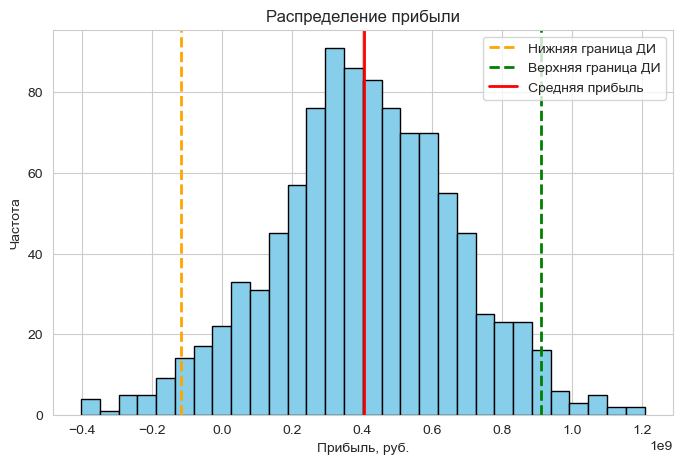

"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"


In [42]:
plot_histogram(income_r1, profit_r1, lower_r1, upper_r1)
print('"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"')

**Распределение прибыли для <u>второго региона</u>**

Построим гистограмму для второго региона.

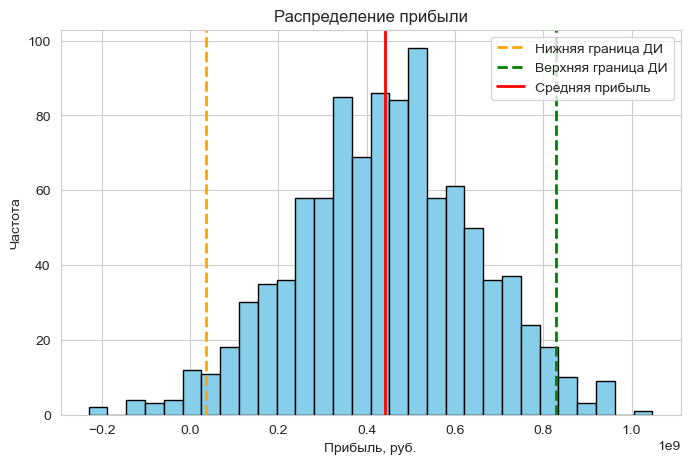

"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"


In [43]:
plot_histogram(income_r2, profit_r2, lower_r2, upper_r2)
print('"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"')

**Распределение прибыли для <u>третьего региона</u>**

Построим гистограмму для третьего региона.

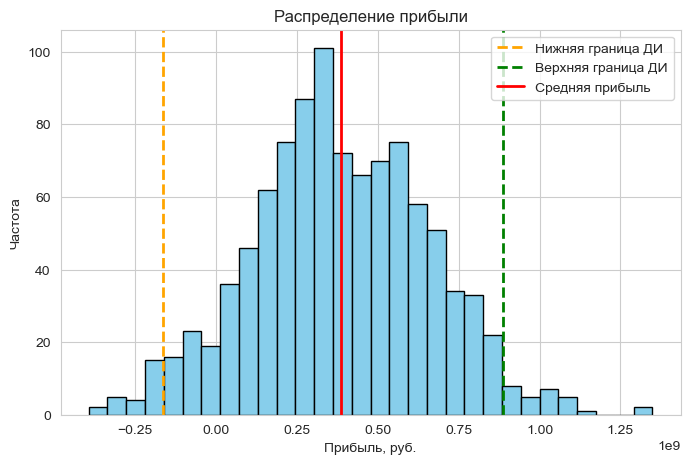

"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"


In [44]:
plot_histogram(income_r3, profit_r3, lower_r3, upper_r3)
print('"1e9" равно "1", умноженной на "10 в степени 9", что дает результат "1 000 000 000"')

В получившемся датафреймеможно увидеть, что наибольшую прибыль (`441 504 278.0 руб.`) и минимальный риск (`1.6%`) мы получили для второго региона, кроме того метрика *RMSE* модели линейной регрессии для второго региона самая низкая из полученных (`0.89`). Таким образом, несмотря на меньшие запасы сырья по сравнению с другими двумя регионами, средняя прибыль для второго региона прогнозируется выше, чем для остальных регионов.

<u>**Общий вывод**</u>

Целью данного проекта является выбор лучшего региона для бурения новой скважины. Были исследованы данные по запасам в скважинах трех регионах: в датасетах для каждого региона содержались данные о запасах сырья для `10 тыс.` скважин. Данные не содержали пропусков или дубликатов, поэтому особой обработки не потребовалось. Во всех датафреймах был удален столбец `id` как неинформативный.

После изучения и подготовки данных мы обучили модель линейной регрессии, а так же применили технологию *Bootstrap* с 1000 выборок, чтобы найти распределение прибыли. Применив модель ко всем трем регионам, получили средний запас сырья для каждого региона (первый регион — `92.4`, второй регион — `68.7`, третий регион — `94.8`), а также оценили качество модели для каждого региона, используя метрику *RMSE* (первый регион — `37.8`, второй регион — `0.89`, третий регион — `40.1`).

В ходе работы мы выяснили, что для безубыточного бурения новой скважины необходимо, чтобы объем нефти был больше `111.11 тыс.` баррелей, при этом имеющийся средний запас сырья в представленных регионах (см.выше) получился значительно ниже данного значения.

По результатам был определен `95%`-й доверительный интревал получения прибыли (первый регион — `(-117742136.49486831, 911737050.7514055`, второй регион — `35728489.280851334, 828006639.0043902`, третий регион — `-164785166.1090443, 888206234.1976783`), вероятность убытка была ограничена величиной не более `2.5%`. На основе этих данных был выбран наиболее перспективный регион для разработки `200` скважин.

Несмотря на сравнительно невысокие предсказанные запасы сырья в `68.7 млн.` баррелей, делаем выбор в пользу разработки `200` скважин во **втором регионе** (датасет `geo_data_1.csv`), поскольку модель линейной регресиии имеет самое низкое значение метрики *RMSE* (`0.89`), средняя прибыль для данного региона составляет `441 504 278.0 руб.` и риск возникновения убытков — `1.6%.`